# Análisis expresión diferencial - datos con replicas biológicas

Replico algunos pasos del taller, agregando apuntes y modificaciones que considere apropiadas de acuerdo a la documentación de edgeR.

In [1]:
# Required libraries validation
missing_packages <- character()
for (package in c(
  "edgeR"
)) {
  if (!require(package, quietly = TRUE, character.only = TRUE)) {
    missing_packages <- append(missing_packages, package)
  }
}

if (length(missing_packages) > 0) {
  stop(
    sprintf(
      "Missing the following packages: %s",
      paste(missing_packages, collapse = ", ")
    ),
    call. = FALSE
  )
}


## 1. Load data

In [2]:
data <- read.table(
  file = "Private_Data/A549citap/A549_real_Ciptap.total.merged.txt",
  header = TRUE, row.names = 1
)


# By default, factor is in alphabetical order
## to change the reference level: relevel(group, ref="new_reference")
group <- factor(c("Ce", "Ce", "Cy", "Cy", "Nu", "Nu"))
data <- DGEList(counts = data, group = group)
head(data)


An object of class "DGEList"
$counts
                                         A549CellCiptapRep3 A549CellCiptapRep4
chr10_AsnGTT_22518418_22518448_5tRNAr                 21324              20495
chr10_AsnGTT_22518438_22518511_total                  21831              21065
chr10_AsnGTT_22518501_22518531_3tRNAr                   207                232
chr10_PseudoCAA_34591396_34591426_5tRNAr                  3                  0
chr10_PseudoCAA_34591416_34591483_total                   3                  0
chr10_PseudoCAA_34591473_34591503_3tRNAr                  3                  0
                                         A549CytosolCiptapRep3
chr10_AsnGTT_22518418_22518448_5tRNAr                    20115
chr10_AsnGTT_22518438_22518511_total                     20373
chr10_AsnGTT_22518501_22518531_3tRNAr                      276
chr10_PseudoCAA_34591396_34591426_5tRNAr                     0
chr10_PseudoCAA_34591416_34591483_total                      0
chr10_PseudoCAA_34591473_34591503_3tRNAr                     0
                                         A549CytosolCiptapRep4
chr10_AsnGTT_22518418_22518448_5tRNAr                     2626
chr10_AsnGTT_22518438_22518511_total                      2693
chr10_AsnGTT_22518501_22518531_3tRNAr                       65
chr10_PseudoCAA_34591396_34591426_5tRNAr                     0
chr10_PseudoCAA_34591416_34591483_total                      0
chr10_PseudoCAA_34591473_34591503_3tRNAr                     0
                                         A549NucleusCiptapRep3
chr10_AsnGTT_22518418_22518448_5tRNAr                     1770
chr10_AsnGTT_22518438_22518511_total                      1839
chr10_AsnGTT_22518501_22518531_3tRNAr                       67
chr10_PseudoCAA_34591396_34591426_5tRNAr                     0
chr10_PseudoCAA_34591416_34591483_total                      1
chr10_PseudoCAA_34591473_34591503_3tRNAr                     1
                                         A549NucleusCiptapRep4
chr10_AsnGTT_22518418_22518448_5tRNAr                     9826
chr10_AsnGTT_22518438_22518511_total                     10038
chr10_AsnGTT_22518501_22518531_3tRNAr                      161
chr10_PseudoCAA_34591396_34591426_5tRNAr                     0
chr10_PseudoCAA_34591416_34591483_total                      0
chr10_PseudoCAA_34591473_34591503_3tRNAr                     0

$samples
                      group lib.size norm.factors
A549CellCiptapRep3       Ce 58393208            1
A549CellCiptapRep4       Ce 81517906            1
A549CytosolCiptapRep3    Cy 72547811            1
A549CytosolCiptapRep4    Cy  2514860            1
A549NucleusCiptapRep3    Nu  1803277            1
A549NucleusCiptapRep4    Nu 25392617            1

## 2. Filtering

Nótese el cambio en los tamaños de las bibliotecas:

In [3]:
# filtering keeps genes that have CPM >= CPM.cutoff in MinSampleSize samples,
#   where CPM.cutoff = min.count/median(lib.size)*1e6 and MinSampleSize is the
#   smallest group sample size or, more generally, the minimum inverse leverage
#   computed from the design matrix.

# keep <- filterByExpr(data, group = group, min.count = 10)
keep <- rowSums(cpm(data) > 100) >= 1
data <- data[keep, , keep.lib.sizes = FALSE]
data$samples


,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
A549CellCiptapRep3,Ce,57972247,1
A549CellCiptapRep4,Ce,81008385,1
A549CytosolCiptapRep3,Cy,72015467,1
A549CytosolCiptapRep4,Cy,2455607,1
A549NucleusCiptapRep3,Nu,1759300,1
A549NucleusCiptapRep4,Nu,25185439,1


## 3. Normalization

edgeR realiza la normalización mediante factores de corrección en el modelo. NO TRANSFORMA los datos. NO se debe ingresar datos transformados tampoco (e.g. RPKM o FPKM)

- En general, solo se necesita normalizar __efectos específicos de muestra__. Por ejemplo, el tamaño del gen influencia el conteo de reads, pero al comparar entre muestras cada gen, estos al tener la misma longitud, en principio, tiene un efecto pequeño e históricamente no se suele tener en cuenta.
- La profundidad de secuenciación afecta el conteo de lecturas. edgeR ajusta este efecto automáticamente.
- Históricamente el contenido GC cambia poco entre muestras, pero algunos estudios han mostrado efectos __específicos de muestra__.
- Genes muy expresados pueden causar que otros sean sub-muestreados. 

In [4]:
# Calculate scaling factors to convert the raw library sizes for a
#   set of sequenced samples into normalized effective library sizes.

# normLibSizes is the new name for calcNormFactors. The two functions
#   are equivalent but calcNormFactors will eventually be retired.

# method TMMwsp: This is a variant of TMM that is intended to have more stable
#   performance when the counts have a high proportion of zeros.
data_normalized <- normLibSizes(data, method = "TMMwsp")


> "The effective library sizes for use in downstream analysis
are lib.size \* norm.factors where lib.size contains the original library sizes and norm.factors
is the vector of scaling factors computed by this function."

Nótese como ha cambiado el data frame samples. lib.size se mantiene, lo que cambia es norm.factors:

In [5]:
cat("Samples data after normalization:")
data_normalized$samples


Samples data after normalization:

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
A549CellCiptapRep3,Ce,57972247,0.7471236
A549CellCiptapRep4,Ce,81008385,0.6731451
A549CytosolCiptapRep3,Cy,72015467,0.7039582
A549CytosolCiptapRep4,Cy,2455607,2.0801886
A549NucleusCiptapRep3,Nu,1759300,1.7577137
A549NucleusCiptapRep4,Nu,25185439,0.7725047


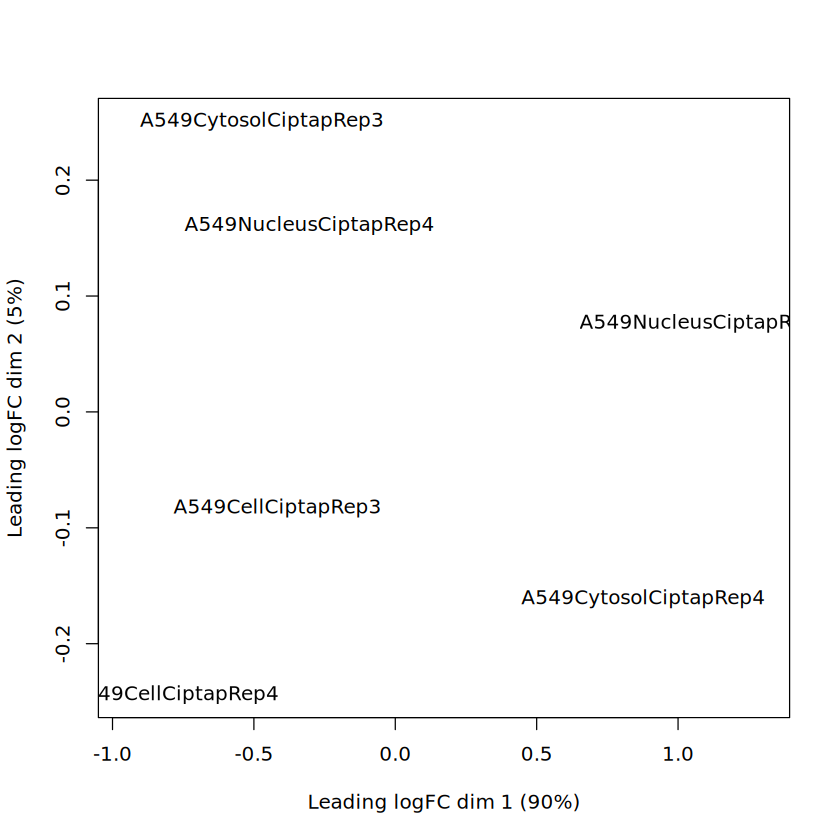

In [6]:
# Data exploration
plotMDS(data_normalized)


## 4. General experiments (i.e., multiple factors) - Dispersion estimation

>"Assuming that an estimate is available for $\Phi_g$, so the variance can be evaluated for any value of $\mu_{gi}$, GLM theory can be used to fit a log-linear model for each gene"

$$\text{log }\mu_{gi} = x_i^T \beta_g + \text{log } N_i$$

- $x_i^T $ covariates vector specifying treatment conditions
- $ \beta_g$ regresión coefficients vector

Notice the new components added to data:

In [7]:
cat("Before dispersion estimation:\n")
cat(paste("  -", names(data_normalized), collapse = "\n"))


Before dispersion estimation:
  - counts
  - samples

In [8]:
# Dispersion estimation

# here, the firs group is the intersect; then, the first coefficient
#   will measure the baseline logCPM, and the later columns are
#   relative to the baseline
design <- model.matrix(~group, data = data$samples)

# Estimate Common, Trended and Tagwise Negative Binomial dispersions
#   by weighted likelihood empirical Bayes
data_normalized <- estimateDisp(data_normalized, design)
cat("After dispersion estimation:\n")
cat(paste("  -", names(data_normalized), collapse = "\n"))


After dispersion estimation:
  - counts
  - samples
  - design
  - common.dispersion
  - trended.dispersion
  - tagwise.dispersion
  - AveLogCPM
  - trend.method
  - prior.df
  - prior.n
  - span

Common dispersion:  0.2769269 


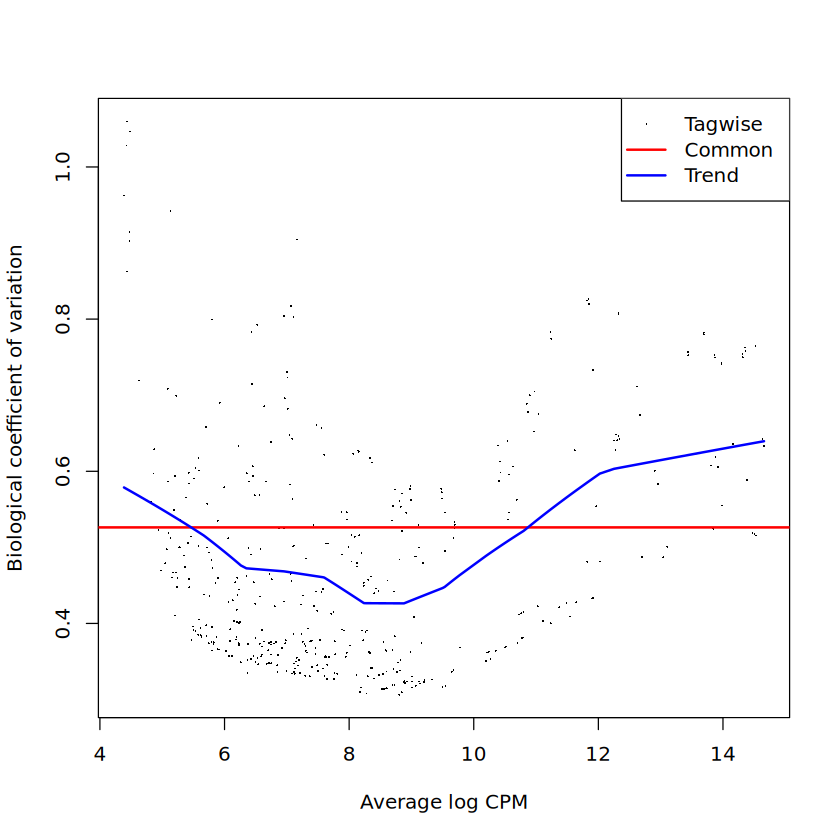

In [9]:
cat("Common dispersion: ", data_normalized$common.dispersion, "\n")
plotBCV(data_normalized)


## 5. General experiments (i.e., multiple factors) - Model fit and DE genes testing

>"The QL F-test is preferred as it reflects the uncertainty in estimating the dispersion for each gene. It provides more robust and reliable error rate control when the number of replicates is small."

In [10]:
# Model Fit
# Fit a negative binomial generalized log-linear model to the read counts for
#   each gene Estimate the genewise quasi-dispersions with empirical
#   Bayes moderation.

fit <- glmQLFit(data_normalized)
cat("fit is a 'DGEGLM' class object:\n")
cat(paste("  -", names(fit), collapse = "\n"))


fit is a 'DGEGLM' class object:
  - coefficients
  - fitted.values
  - deviance
  - method
  - counts
  - unshrunk.coefficients
  - df.residual
  - design
  - offset
  - dispersion
  - prior.count
  - AveLogCPM
  - df.residual.zeros
  - df.prior
  - var.post
  - var.prior
  - samples

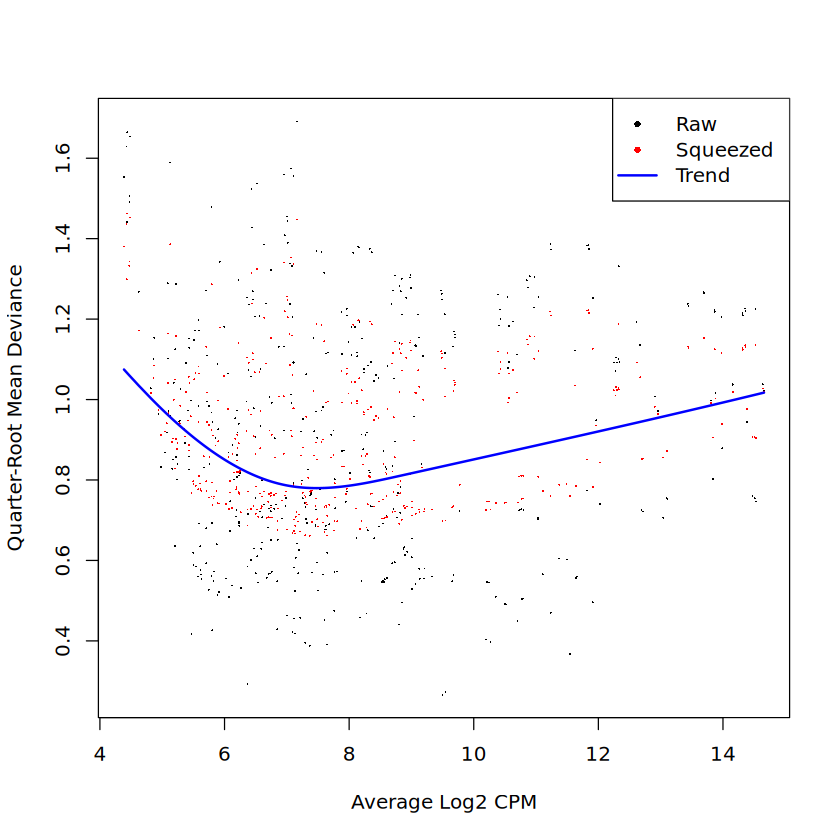

In [11]:
plotQLDisp(fit)


In [12]:
# Quasi-Likelihood F-Tests: Conduct genewise quasi F-tests
#   for a given coefficient or coefficient contrast.

# - coef: integer or character index vector indicating which
#   coefficients of the linear model are to be tested equal to zero.
#   Default is  ncol(glmfit$design)

# - contrast: numeric vector or matrix specifying one or more contrasts
#   of the linear model coefficients to be tested equal to zero.

qlf_last_vs_1 <- glmQLFTest(glmfit = fit)
cat("comparison:", qlf_last_vs_1$comparison)


comparison: groupNu

In [13]:
# Other examples

# H0: coef_3 - coef_1 = 0
qlf_3_vs_1 <- glmQLFTest(glmfit = fit, coef = 3)
cat("qlf_3_vs_1 comparison:", qlf_3_vs_1$comparison, "\n")

# H0: coef_2 - coef_1 = 0
qlf_2_vs_1 <- glmQLFTest(glmfit = fit, coef = 2)
cat("qlf_2_vs_1 comparison:", qlf_2_vs_1$comparison, "\n")

# H0: coef_3 - coef_2 = 0
qlf_3_vs_2 <- glmQLFTest(glmfit = fit, contrast = c(0, -1, 1))
cat("qlf_3_vs_2 comparison:", qlf_3_vs_2$comparison, "\n")


qlf_3_vs_1 comparison: groupNu 
qlf_2_vs_1 comparison: groupCy 
qlf_3_vs_2 comparison: -1*groupCy 1*groupNu 


>"It might be of interest to find genes that are DE between any of the groups, without specifying before-hand which groups might be different."

In [14]:
# ANOVA-like test for any differences
qlf_any <- glmQLFTest(glmfit = fit, coef = 2:ncol(fit$design))
cat("qlf_any comparison:", qlf_any$comparison, "\n")


qlf_any comparison: groupCy groupNu 


In [15]:
# Table rows = min(n, number of genes with adjusted p-value <= cutoff p-value)
#   default cutoff is 1!!!
# FDR: false discovery rate (only when adjust.method is "BH", "BY" or "fdr")
topTags(qlf_2_vs_1)


,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr17_ProCGG_8126131_8126161_5tRNAr,1.8219405,7.488156,13.383011,0.01114775,0.7063384
chr16_ProTGG_3234113_3234143_5tRNAr,1.2262359,8.823780,9.561817,0.02213236,0.7063384
chr16_ProTGG_3238155_3238185_3tRNAr,1.3495025,8.553441,9.306744,0.02331879,0.7063384
chr16_ProTGG_3234133_3234204_total,1.1669233,8.983703,7.815329,0.03231372,0.7063384
chr16_ProTGG_3238094_3238165_total,1.2571971,8.732222,7.520138,0.03463230,0.7063384
chr6_GluCTC_126101373_126101403_5tRNAr,0.9154560,8.401212,7.489307,0.03488733,0.7063384
chr1_GluCTC_145399213_145399243_5tRNAr,0.9201261,8.883381,7.463848,0.03509985,0.7063384
chr6_GluCTC_28950037_28950067_3tRNAr,0.9021876,8.872419,7.258284,0.03688189,0.7063384
chr19_GlyTCC_4724143_4724173_3tRNAr,1.7134834,5.160221,7.056060,0.03875693,0.7063384


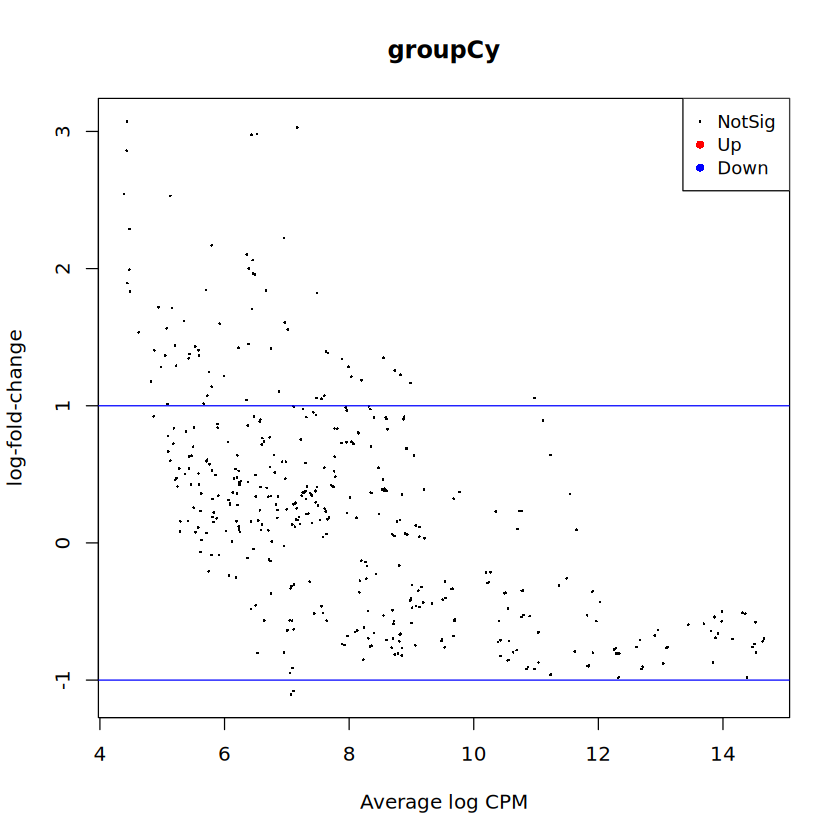

In [16]:
plotMD(qlf_2_vs_1)
abline(h = c(-1, 1), col = "blue")


#### 5.1. A more general approach:

Tuning design and contrast, the glm approach allows an infinite variety of comparisons.

In [17]:
# define a coefficient for the expression level of each group

# not to include an intercept column and instead to
#   include a column for each group.
design2 <- model.matrix(~ 0 + group, data = data_normalized$samples)
colnames(design2) <- levels(data_normalized$samples$group)
data_normalized2 <- estimateDisp(data_normalized, design)
fit2 <- glmQLFit(data_normalized2, design2)


In [18]:
# esto en esencia es igual a qlf_2_vs_1
qlf_alt_2_vs_1 <- glmQLFTest(fit2, contrast = c(-1, 1, 0))
cat("qlf_alt_2_vs_1comparison:", qlf_alt_2_vs_1$comparison, "\n")
abs(topTags(qlf_2_vs_1)$table - topTags(qlf_alt_2_vs_1)$table) < 1e-14


qlf_alt_2_vs_1comparison: -1*Ce 1*Cy 


,logFC,logCPM,F,PValue,FDR
chr17_ProCGG_8126131_8126161_5tRNAr,TRUE,TRUE,TRUE,TRUE,TRUE
chr16_ProTGG_3234113_3234143_5tRNAr,TRUE,TRUE,TRUE,TRUE,TRUE
chr16_ProTGG_3238155_3238185_3tRNAr,TRUE,TRUE,TRUE,TRUE,TRUE
chr16_ProTGG_3234133_3234204_total,TRUE,TRUE,TRUE,TRUE,TRUE
chr16_ProTGG_3238094_3238165_total,TRUE,TRUE,TRUE,TRUE,TRUE
chr6_GluCTC_126101373_126101403_5tRNAr,TRUE,TRUE,TRUE,TRUE,TRUE
chr1_GluCTC_145399213_145399243_5tRNAr,TRUE,TRUE,TRUE,TRUE,TRUE
chr6_GluCTC_28950037_28950067_3tRNAr,TRUE,TRUE,TRUE,TRUE,TRUE
chr19_GlyTCC_4724143_4724173_3tRNAr,TRUE,TRUE,TRUE,TRUE,TRUE
chr16_ArgCCT_3202901_3202973_total,TRUE,TRUE,TRUE,TRUE,TRUE


The contrast vector can be made with the function __makeContrasts__:

In [19]:
# A single contrast
NuvsCe <- makeContrasts(Nu - Ce, levels = design2)
qlf_NuvsCe <- glmQLFTest(fit2, contrast = NuvsCe)
cat(qlf_NuvsCe$comparison)


-1*Ce 1*Nu

In [20]:
# Multiple contrasts

my_contrasts <- makeContrasts(
  CyvsCe = Cy - Ce, # c(-1,1,0)
  NuvsCe = Nu - Ce, # c(-1,0,1)
  NuvsCy = Nu - Cy, # c(0,-1,1)
  levels = design2
)

qlf_list <- list()
for (current_contrast in colnames(my_contrasts)) {
  qlf_current <- glmQLFTest(fit2, contrast = my_contrasts[, current_contrast])
  # top_current <- topTags(qlf_current, n = nrow(fit2$counts))
  current_i <- length(qlf_list) + 1
  qlf_list[[current_contrast]] <- summary(decideTests(qlf_current))
}
qlf_list


$CyvsCe
       -1*Ce 1*Cy
Down            0
NotSig        516
Up              0

$NuvsCe
       -1*Ce 1*Nu
Down            0
NotSig        516
Up              0

$NuvsCy
       -1*Cy 1*Nu
Down            0
NotSig        516
Up              0


## About design and contrasts

Be aware of the model desing when making the contrasts; for example:

_Contrasts under a given design:_
| comparison | ~group | ~0+group |
| :-: | :-: | :-: |
| group2 vs group1 | (0, 1, 0) | (-1, 1, 0) |
| group 3 vs group1 | (0, 0, 1) | (-1, 0, 1)|
| group 3 vs group 2 | (0, -1, 1) | (0, -1, 1) |
| | (-1, 1, 0) | (-2, 1, 0) |
| | (1, 1, 0) | (0, 1, 0) |
| | (1, 1, 1) | (-1, 1, 1) |
| | (2, 2, 2) | (-2, 2, 2) |


In [21]:
design
design2


,(Intercept),groupCy,groupNu
A549CellCiptapRep3,1,0,0
A549CellCiptapRep4,1,0,0
A549CytosolCiptapRep3,1,1,0
A549CytosolCiptapRep4,1,1,0
A549NucleusCiptapRep3,1,0,1
A549NucleusCiptapRep4,1,0,1


,Ce,Cy,Nu
A549CellCiptapRep3,1,0,0
A549CellCiptapRep4,1,0,0
A549CytosolCiptapRep3,0,1,0
A549CytosolCiptapRep4,0,1,0
A549NucleusCiptapRep3,0,0,1
A549NucleusCiptapRep4,0,0,1


In [36]:
contrast1 <- c(1, 1, 1)
contrast2 <- c(-1, 1, 1)
t1 <- glmLRT(glmfit = glmFit(data_normalized, design), contrast = contrast1)
t2 <- glmLRT(glmfit = glmFit(data_normalized2, design2), contrast = contrast2)
total_tags <- nrow(data_normalized$counts)
all((decideTests(t2) ==
  decideTests(t1))[, 1])


[1] TRUE

# Bibliography

[1] Y. Chen, L. Chen, A. T. L. Lun, P. L. Baldoni, and G. K. Smyth, “edgeR 4.0: powerful differential analysis of sequencing data with expanded functionality and improved support for small counts and larger datasets.” Jan. 24, 2024. doi: 10.1101/2024.01.21.576131.

[2] Y. Chen et al., “edgeR.” 2017. doi: 10.18129/B9.BIOC.EDGER.

[3] Y. Chen, D. McCarthy, P. Baldoni, M. Robinson, and G. Smyth, “edgeR: differential analysis of sequence read count data User’s Guide.” [Online]. Available: https://bioconductor.org/packages/release/bioc/html/edgeR.html

In [23]:
sessionInfo()


R version 4.3.3 (2024-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 24.04 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.12.0 
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: America/Bogota
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] edgeR_4.0.16 limma_3.58.1

loaded via a namespace (and not attached):
 [1] digest_0.6.35     IRdisplay_1.1     utf8_1.2.4        base64enc_0.1-3  
 [5] fastmap_1.2.0     lattice_0.22-6    splines_4.3.3     glue_1.7.0       
 [9] htmltools_0.5.8.1 repr_1.1.7       